### LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tifffile as tiff
import pytorch_lightning as pl

from torch.utils.data import Dataset
import albumentations as A

from typing import Optional, List

### UTILITIES

In [2]:
# Viz.
def plot_sample(
    ax,
    item,
    annotate: bool = False
):
    """
    Plot a specified samples.
    
    Parameters
    ----------
    ax
        A dataframe with the metadata on the samples.
    item
        A pytorch Dataset instance.
    annotate
        Optionally, whether to annotate the samples or not.
    """
    # Show image.
    ax.imshow(item['img_arr'])
    
    # Add annotations if necessary.
    if annotate:
        ax.imshow(item['mask'],cmap='coolwarm', alpha=0.5)

    ax.axis("off")
    ax.set_title(f"{item['metadata'].organ}, {item['metadata'].sex}")
    
    

def plot_samples(
    dataset,
    indices: list,
    annotate: bool = False,
    cols: int = 2,
    figsize: tuple = (18, 5)
):
    """
    Plot a grid of specified samples.
    
    Parameters
    ----------
    hhhhb_dataset
        A pytorch Dataset object.
    indices
        A list of the item indices to plot.
    annotate
        Optionally, whether to annotate the samples or not.
    cols
        Optionally, the number of columns for the grid.
    figsize
        Optionally, a tuple containg the figure size in the form (width, height).
    """
    # Infer rows.
    items = len(indices)
    rows, x = items // cols, items % cols # x carries the reminder if it exists.
    rows = rows if x == 0 else rows + 1
    
    # Set up figure.
    if not (isinstance(figsize, tuple) and len(figsize)==2):
        raise ValueError("Please provide a valid figsize i.e. (width, height)")
    fig = plt.figure(figsize=(figsize[0], figsize[1] * rows))
    
    # Plotting loop.
    for idx, index in enumerate(indices):
        ax = fig.add_subplot(rows, cols, idx + 1)
        plot_sample(ax, dataset[index], annotate)
        
    plt.tight_layout()

In [3]:
def mask2rle(
    mask:np.array
):
    """
    Encode mask using run length encoding.
    
    Parameters
    ----------
    mask
         A numpy array, 1 - mask, 0 - background
    
    Returns
    -------
    A run length encoding of the mask as a string formated.
    
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(
    mask_rle: str, 
    shape: tuple= (3000,3000)
):
    """
    Convert a run length encoding to a mask.
    
    Parameters
    ----------
    mask_rle
        A run-length as string formated (start length).
    shape
        The shape of the image to which the rle is to be unencoded (width,height).
        
    Returns
    -------
        A numpy array, 1 - mask, 0 - background.
        
    Notes
    -----
    Reference: https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
# The dataset.
class HHHHBDataset(Dataset):
    """
    Reads in images, transfroms pixel values and serves a dictionary containing the image ids,
    image tensors and the label masks.
    """
    def __init__(
        self,
        data: pd.DataFrame,
        transforms: Optional[list] = None
    ):
        """
        Instantiate the HHHHBDataset.
        
        Parameters
        ----------
        data
            A dataframe with a row for each biopsy image.
        transforms
            Optionally, a list of transforms to apply to the feature data. (Augmentations).
        """
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return self.data['id'].nunique()
    
    def __getitem__(
        self, 
        idx: int
    ):
        # Loads an n-channel image from a chip-level dataframe.
        img_metadata = self.data.loc[idx]
        
        # Read in the image.
        img_arr = tiff.imread(img_metadata.file_path)
        
        # Load mask.
        mask_arr = rle2mask(img_metadata.rle, (img_metadata.img_width, img_metadata.img_height))
        
        # Apply data augmentations, if provided.
        if self.transforms:
            augmented = self.transforms(image=img_arr, mask=mask_arr)
            # Get augmentations.
            img_arr = augmented['image']
            mask_arr = augmented['mask']
        
            
        # Prepare the dictionary for item.
        item = {
            "id": img_metadata["id"], 
            "img_arr": img_arr, 
            "mask": mask_arr,
            "metadata": img_metadata[['organ', 'data_source', 'pixel_size', 'tissue_thickness', 'age', 'sex']] # Metadata
        }
        return item

### DATA
Preliminary EDA [here.](https://www.kaggle.com/code/bomera/hhhhb-eda)

In [5]:
data_path = '../input/hubmap-organ-segmentation' # Path to the data.
train = pd.read_csv(f"{data_path}/train.csv")
test = pd.read_csv(f"{data_path}/test.csv")
submission = pd.read_csv(f"{data_path}/sample_submission.csv")

In [6]:
# Add file paths.
train['file_path'] = data_path + '/train_images/' + train['id'].astype(str) + '.tiff'

### DATASET

In [7]:
# Test dataset.
hhhhb_dataset = HHHHBDataset(train)
len(hhhhb_dataset)

351

In [8]:
# Test Augmentations.
transforms = A.Compose(
    [
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ]
)

hhhhb_dataset_ = HHHHBDataset(train, transforms=transforms)
len(hhhhb_dataset_)

351

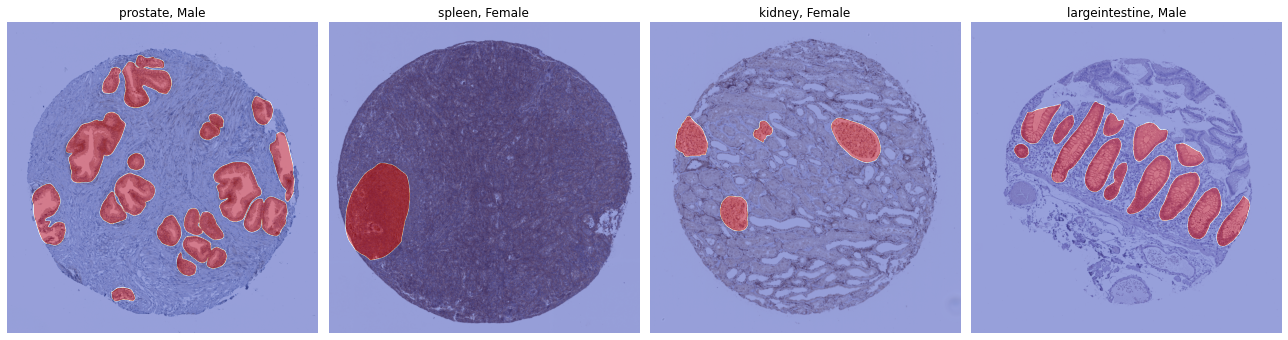

In [9]:
plot_samples(hhhhb_dataset, indices=[1, 4, 5, 6], annotate=True, cols=4)

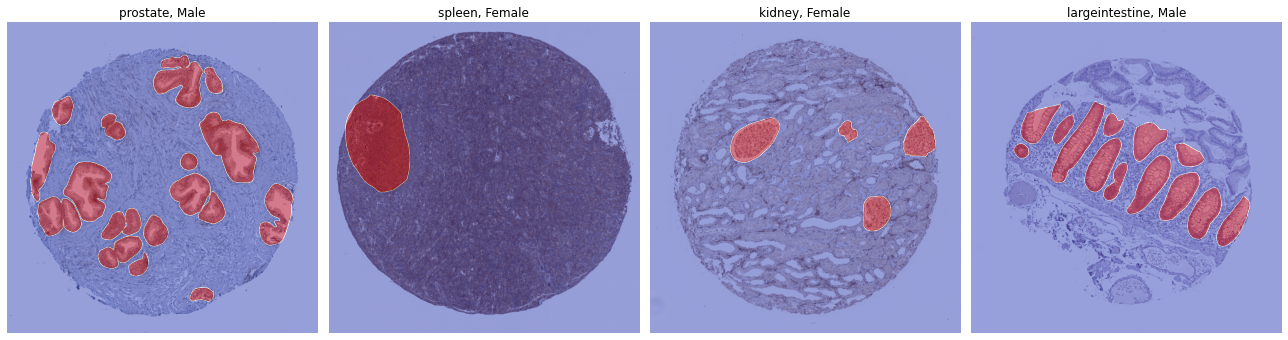

In [10]:
plot_samples(hhhhb_dataset_, indices=[1, 4, 5, 6], annotate=True, cols=4)

In [11]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[0].imshow(mask)
    else:
        f, ax = plt.subplots(1, 2, figsize=(15, 8))

        ax[0].imshow(original_image)
        ax[0].imshow(original_mask, cmap='coolwarm', alpha=0.5)
        ax[0].set_title('Original image, mask', fontsize=fontsize)
        
        ax[1].imshow(image)
        ax[1].imshow(mask, cmap='coolwarm', alpha=0.5)
        ax[1].set_title('Transformed image, mask', fontsize=fontsize)

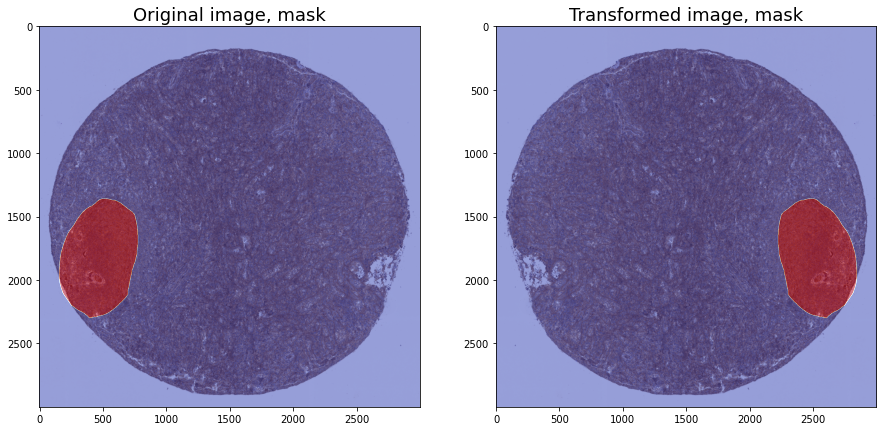

In [12]:
image, mask = hhhhb_dataset[4]["img_arr"], hhhhb_dataset[4]["mask"]

aug = A.Compose(
    [
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ]
)
augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)